# Image Captioning using CNN and NLP

## Team 06
- Mann Purohit
- Sarvagna Shukla
- Foram Shah

In [1]:
%config Completer.use_jedi = False

## Importing Libraries

In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf
import numpy as np
import pandas as pd
import cv2
from glob import glob
import regex as re
import matplotlib.pyplot as plt
import collections
import random
import requests
import time
from PIL import Image
from tqdm.auto import tqdm

/opt/anaconda3/envs/new_tensorflow/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Path where flickr images are stored
IMAGES_DIR = '/Users/mannpurohit/NEU/Capstone/Image_Captioning/archive/Flickr_Data/Images/'

In [4]:
images = glob(IMAGES_DIR+'*.jpg')
print("Total no.of Flickr images ", len(images))

Total no.of Flickr images  8091


### Plot first 2 images

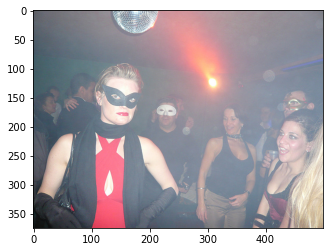

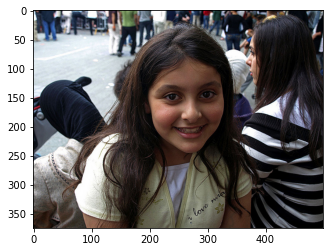

In [5]:
import matplotlib.pyplot as plt

for i in range(2):
    plt.figure()
    img = cv2.imread(images[i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)

### Mapping Image to captions
##### Each image has 5 different captions

In [117]:
remove = re.compile('2258277193_586949ec62.jpg.1')

In [120]:
remove.search('/ewd/258277193_586949ec62.jpg.1#2') is None

True

In [157]:
captions_dict = {}
unique_images = set()
captions_path = '/Users/mannpurohit/NEU/Capstone/Image_Captioning/archive/Flickr_Data/Flickr_TextData/Flickr8k.token.txt'
remove = re.compile('jpg\.1')
with open(captions_path, 'r') as f:
    line = f.readline()
    while line:
        if remove.search(line) is None:
#         caption_id = line[:re.search(r'#[0-9]\s', line).span()[0]+2]
#         image_caption = line[re.search(r'#[0-9]\s', line).span()[1]:].strip()
            caption_id, image_caption = line.split('\t')
            captions_dict[caption_id] = image_caption
            unique_images.add(caption_id[:-2])
        line = f.readline()
#         print(line)
# unique_images.remove('2258277193_586949ec62.jpg.1')

In [158]:
len(captions_dict)

40455

##### Preprocessing Text

In [160]:
def preprocess_caption(text):
    '''
    This function will pre-process text
    '''
    
    # making it lowercase
    text = text.lower()

    # remove punctuations
    text = re.sub(r'[^\w\s]', '', text)

    # remove extra spaces
    text = re.sub('\s+', ' ', text)
    text = text.strip()

    # add [start] and [end] special token
    text = '[start] ' + text + ' [end]'

    return text

In [161]:
# Storing preprocessed captions
pp_captions_dict = {}
for img_id, caption in captions_dict.items():
    pp_captions_dict[img_id] = preprocess_caption(caption)

In [162]:
# Load the Inception V3 model
inception_v3 = tf.keras.applications.InceptionV3(
    include_top=False,
    weights='imagenet'
)
# make training of inception v3's weights untrainable
inception_v3.trainable = False

##### Preprocessing Images

In [163]:
def load_image(path):
    '''
    pre-process image
    '''
    
    import tensorflow as tf

    # load image from disk
    img = tf.io.read_file(path)

    # make it a tensor
    img = tf.image.decode_jpeg(img, channels=3)

    # resize it to 300 X 300
    img = tf.image.resize(img, (300, 300))

    # apply inception v3 preprocessing, Normalize values from [0,255] to [-1,1]
    img = tf.keras.applications.inception_v3.preprocess_input(img)

    return img, path

In [164]:
# we will batch image paths using TensorFlow Dataset
image_dataset = tf.data.Dataset.from_tensor_slices([IMAGES_DIR+img_path for img_path in list(unique_images)])
image_dataset = image_dataset.map(
  load_image, num_parallel_calls=tf.data.AUTOTUNE).batch(16)

In [165]:
# iterate through all the image paths, load it with the
# `load_img()` function and save it in the feature_vectors 
# directory

fv_path = f'feature_vectors/'
os.makedirs(fv_path, exist_ok=True)

for img, paths in tqdm(image_dataset, total=len(image_dataset)):
    feature_vector = inception_v3(img)
    # the feature_vector is of shape
    # (batch_size, 8, 8, 2048)
    
    feature_vector = tf.reshape(
        feature_vector,
        (feature_vector.shape[0], -1, feature_vector.shape[3])
    )
    # now it is of shape (batch_size, 8*8, 2048) = 
    # (batch_size, 64, 2048)
        
    for fv, path in zip(feature_vector, paths):
        path = path.numpy().decode("utf-8")
        path = fv_path + path.split('/')[-1]
        np.save(path, fv.numpy())

100%|█████████████████████████████████████████| 506/506 [15:54<00:00,  1.89s/it]


In [166]:
# Let's add the feature_vector column, which will 
# include the path to each image's feature vector.

captions = pd.DataFrame({'image': captions_dict.keys(), 'caption': captions_dict.values()})
captions['image'] = captions['image'].apply(lambda x: x.split('#')[0])
captions['image'] = IMAGES_DIR + captions['image']

captions['feature_vector'] = captions['image'].apply(
    lambda x: x.replace('archive/Flickr_Data/Images', 'feature_vectors') + '.npy'
)

captions = captions[['image', 'feature_vector', 'caption']]
captions.head()

,image,feature_vector,caption
0,/Users/mannpurohit/NEU/Capstone/Image_Captioni...,/Users/mannpurohit/NEU/Capstone/Image_Captioni...,A child in a pink dress is climbing up a set o...
1,/Users/mannpurohit/NEU/Capstone/Image_Captioni...,/Users/mannpurohit/NEU/Capstone/Image_Captioni...,A girl going into a wooden building .\n
2,/Users/mannpurohit/NEU/Capstone/Image_Captioni...,/Users/mannpurohit/NEU/Capstone/Image_Captioni...,A little girl climbing into a wooden playhouse...
3,/Users/mannpurohit/NEU/Capstone/Image_Captioni...,/Users/mannpurohit/NEU/Capstone/Image_Captioni...,A little girl climbing the stairs to her playh...
4,/Users/mannpurohit/NEU/Capstone/Image_Captioni...,/Users/mannpurohit/NEU/Capstone/Image_Captioni...,A little girl in a pink dress going into a woo...


In [167]:
# for i in range(5):
#     er = 12085+i
#     img = cv2.imread(captions['image'][er])
#     img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#     plt.imshow(img)
#     print(captions['caption'][er])

In [168]:
print(captions['image'][0])
print(captions['feature_vector'][0])

/Users/mannpurohit/NEU/Capstone/Image_Captioning/archive/Flickr_Data/Images/1000268201_693b08cb0e.jpg
/Users/mannpurohit/NEU/Capstone/Image_Captioning/feature_vectors/1000268201_693b08cb0e.jpg.npy


## Text Vectorization

In [169]:
# Text vectorizer for captions
max_length = 40          # maximum number of words in sentence
vocabulary_size = 5000   # maximum vocabulary size

tokenizer = tf.keras.layers.TextVectorization(
    max_tokens=vocabulary_size,
    standardize=None,
    output_sequence_length=max_length)

# the adapt function below will build the vocabulary
tokenizer.adapt(captions['caption'])

In [170]:
# Let's test the `tokenizer`
tokenizer(['a dog running'])

<tf.Tensor: shape=(1, 40), dtype=int64, numpy=
array([[ 2, 10, 34,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0]])>

In [171]:
import pickle
pickle.dump(tokenizer.get_vocabulary(), open('vocab_encdec.file', 'wb'))

In [172]:
# creating word2idx and idx2word so we can easily covert word to index and vice versa

word2idx = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary())

idx2word = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary(),
    invert=True)

## Train-Validation Split

In [178]:
# '/Users/mannpurohit/NEU/Capstone/Image_Captioning/feature_vectors/2258277193_586949ec62.jpg.1.npy' in captions['feature_vector'].values

In [174]:
# Train-Validation split
# fv means feature vectors

fv_to_cap_vector = collections.defaultdict(list)
for fv, cap in zip(captions['feature_vector'], captions['caption']):
    fv_to_cap_vector[fv].append(cap)

fv_keys = list(fv_to_cap_vector.keys())
random.shuffle(fv_keys)

slice_index = int(len(fv_keys)*0.8)
fv_name_train_keys, fv_name_val_keys = fv_keys[:slice_index], fv_keys[slice_index:]

train_feature_vectors = []
train_captions = []
for fvt in fv_name_train_keys:
    capt_len = len(fv_to_cap_vector[fvt])
#     print([fvt], ' ', capt_len)
#     print([fvt]*capt_len)
    train_feature_vectors.extend([fvt] * capt_len)
    train_captions.extend(fv_to_cap_vector[fvt])

val_feature_vectors = []
val_captions = []
for fvv in fv_name_val_keys:
    capv_len = len(fv_to_cap_vector[fvv])
    val_feature_vectors.extend([fvv] * capv_len)
    val_captions.extend(fv_to_cap_vector[fvv])

In [175]:
print(len(train_feature_vectors), len(val_feature_vectors))

32360 8095


In [176]:
# Let's review how train images and captions look like,
print(train_feature_vectors[0])
print()
print(train_captions[0])

/Users/mannpurohit/NEU/Capstone/Image_Captioning/feature_vectors/3415578043_03d33e6efd.jpg.npy

A child covered with paint sits amid trays of multicolored paint on a surface thoroughly saturated with paint .



## Putting image and captions together

In [179]:
# Hyper-Parameters

BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
vocab_size = tokenizer.vocabulary_size()

In [180]:
def load_data(fv_path, caption):
    '''
    This image will take feature vector path and caption string and return
    the loaded feature vector array and apply the `tokenizer`
    to the caption.
    '''

    # Step 1: Load feature vector
    feature_vector = np.load(fv_path.decode('utf-8'))

    # Step 2: Tokenize caption
    tokenized_caption = tokenizer(caption)

    return feature_vector, tokenized_caption

In [181]:
def apply_load_data(feature_vector_t, caption_vectors_t):
    return tf.numpy_function(
        load_data, [feature_vector_t, caption_vectors_t], [tf.float32, tf.int64])

In [183]:
train_dataset = tf.data.Dataset.from_tensor_slices(
    (train_feature_vectors, train_captions))

# apply the `load_data()` function
train_dataset = train_dataset.map(apply_load_data, 
                                  num_parallel_calls=tf.data.AUTOTUNE)

# shuffle and batch
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)


# Do the same for validation set
val_dataset = tf.data.Dataset.from_tensor_slices(
    (val_feature_vectors, val_captions))

val_dataset = val_dataset.map(apply_load_data, 
                              num_parallel_calls=tf.data.AUTOTUNE)

val_dataset = val_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
val_dataset = val_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

In [184]:
img, cap = next(iter(train_dataset))
print('Image shape:', img.shape)
print('Caption shape:', cap.shape)

Image shape: (64, 64, 2048)
Caption shape: (64, 40)


In [185]:
# The Encoder

class CNNEncoder(tf.keras.layers.Layer):

    def __init__(self, embedding_dim):
        super(CNNEncoder, self).__init__()
        # since we have already saved all the feature vectors, we can
        # pass them via a fully connected layer. This will transform it
        # into the shape (batch_size, 64, embedding_dim)
        # if you will not include this layer there won't be any learning at 
        # the encoder part at all.
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

In [186]:
# The Attention mechanism

class BahdanauAttention(tf.keras.layers.Layer):

    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)


    def call(self, features, hidden):
        # I have explained this here:
        hidden_with_time_axis = tf.expand_dims(hidden, 1)
        score = self.V(tf.nn.tanh(self.W1(features) +
                                  self.W2(hidden_with_time_axis)))
        attention_weights = tf.nn.softmax(score, axis=1)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [187]:
# The Decoder

class RNNDecoder(tf.keras.layers.Layer):

    def __init__(self, embedding_dim, units, vocab_size):
        super(RNNDecoder, self).__init__()
        self.units = units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.attention = BahdanauAttention(units)
        self.gru = tf.keras.layers.GRU(
            self.units,
            return_sequences=True,
            return_state=True,
        )
        self.fc1 = tf.keras.layers.Dense(units)
        self.fc2 = tf.keras.layers.Dense(vocab_size)

    def call(self, x, features, hidden):
        # we will calculate attention between image's feature vector and 
        # text's hidden state.
        context_vector, attention_weights = self.attention(features, hidden)
        x = self.embedding(x)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
        output, state = self.gru(x)
        x = self.fc1(output)
        x = tf.reshape(x, (-1, x.shape[2]))
        x = self.fc2(x)
        return x, state, attention_weights


    def reset_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [188]:
encoder = CNNEncoder(embedding_dim)
decoder = RNNDecoder(embedding_dim, units, vocab_size)

In [189]:
optimizer = tf.keras.optimizers.Adam()

def loss_fn(y_true, y_pred):
    # calculate loss
    loss = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')(y_true, y_pred)


    # we will mask out the padding tokens
    mask = y_true != 0
    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask

    return tf.reduce_mean(loss)

In [190]:
loss_history = []

In [191]:
@tf.function
def train_step(img_tensor, target):
    '''
    a forward and backward pass of a single batch
    '''
    # initial loss is zero
    loss = 0

    # initializing the hidden state for each batch
    # because the captions are not related from image to image
    hidden = decoder.reset_state(batch_size=target.shape[0])

    # initial decoder input
    dec_input = tf.expand_dims(target[:, 0], 1)

    with tf.GradientTape() as tape:
        # getting features from encoder
        features = encoder(img_tensor)

        # we will generate the next words with this for loop
        for i in range(1, target.shape[1]):
            # pass features and captions through decoder
            predictions, hidden, _ = decoder(dec_input, features, hidden)

            # calculate loss between the predicted next word and the actual next word
            loss += loss_fn(target[:, i], predictions)

            # teacher forcing
            dec_input = tf.expand_dims(target[:, i], 1)

    # taking the mean of total_loss
    total_loss = (loss / int(target.shape[1]))

    # backward pass
    trainable_variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, trainable_variables)
    optimizer.apply_gradients(zip(gradients, trainable_variables))

    return loss, total_loss

In [199]:
EPOCHS = 4

# The training loop

for epoch in range(EPOCHS):
    start = time.time()
    total_loss = 0

    with tqdm(total=len(train_dataset)) as pbar:

        for (batch, (img_tensor, target)) in enumerate(train_dataset):
            # run the `train_step()` for every batch
            batch_loss, t_loss = train_step(img_tensor, target)
            total_loss += t_loss

            # we will pring loss value after every 100 batch
            if batch % 100 == 0:
                average_batch_loss = batch_loss.numpy()/int(target.shape[1])
                print(f'Epoch {epoch+1} Batch {batch} Loss {average_batch_loss:.4f}')
            
            pbar.update(1)
    
    loss_history.append(total_loss/len(train_dataset))

    print(f'Epoch {epoch+1} Loss {total_loss/len(train_dataset):.6f}')
    print(f'Time taken for 1 epoch {time.time()-start:.2f} sec\n')

  0%|                                           | 1/506 [00:05<48:51,  5.81s/it]

Epoch 1 Batch 0 Loss 0.8824


 20%|████████▏                                | 101/506 [03:02<12:43,  1.89s/it]

Epoch 1 Batch 100 Loss 0.7232


 40%|████████████████▎                        | 201/506 [06:15<09:54,  1.95s/it]

Epoch 1 Batch 200 Loss 0.6754


 59%|████████████████████████▍                | 301/506 [09:33<06:51,  2.01s/it]

Epoch 1 Batch 300 Loss 0.7930


 79%|████████████████████████████████▍        | 401/506 [12:57<03:29,  1.99s/it]

Epoch 1 Batch 400 Loss 0.7169


 99%|████████████████████████████████████████▌| 501/506 [19:18<00:08,  1.62s/it]

Epoch 1 Batch 500 Loss 0.8129


100%|█████████████████████████████████████████| 506/506 [19:25<00:00,  2.30s/it]


Epoch 1 Loss 0.743494
Time taken for 1 epoch 1165.92 sec



  0%|                                           | 1/506 [00:05<48:40,  5.78s/it]

Epoch 2 Batch 0 Loss 0.8062


 20%|████████▏                                | 101/506 [03:09<12:50,  1.90s/it]

Epoch 2 Batch 100 Loss 0.8144


 40%|████████████████▎                        | 201/506 [06:23<10:01,  1.97s/it]

Epoch 2 Batch 200 Loss 0.6974


 59%|████████████████████████▍                | 301/506 [09:41<06:40,  1.96s/it]

Epoch 2 Batch 300 Loss 0.7541


 79%|████████████████████████████████▍        | 401/506 [12:56<03:23,  1.94s/it]

Epoch 2 Batch 400 Loss 0.8115


 99%|████████████████████████████████████████▌| 501/506 [16:12<00:09,  1.92s/it]

Epoch 2 Batch 500 Loss 0.6824


100%|█████████████████████████████████████████| 506/506 [16:21<00:00,  1.94s/it]


Epoch 2 Loss 0.701760
Time taken for 1 epoch 981.02 sec



  0%|                                           | 1/506 [00:05<47:56,  5.70s/it]

Epoch 3 Batch 0 Loss 0.7270


 20%|████████▏                                | 101/506 [03:22<13:21,  1.98s/it]

Epoch 3 Batch 100 Loss 0.7426


 40%|████████████████▎                        | 201/506 [06:41<10:35,  2.08s/it]

Epoch 3 Batch 200 Loss 0.6247


 59%|████████████████████████▍                | 301/506 [09:58<06:39,  1.95s/it]

Epoch 3 Batch 300 Loss 0.6696


 79%|████████████████████████████████▍        | 401/506 [17:13<02:52,  1.64s/it]

Epoch 3 Batch 400 Loss 0.6648


 99%|████████████████████████████████████████▌| 501/506 [20:14<00:09,  1.81s/it]

Epoch 3 Batch 500 Loss 0.6787


100%|█████████████████████████████████████████| 506/506 [20:22<00:00,  2.42s/it]


Epoch 3 Loss 0.664418
Time taken for 1 epoch 1222.56 sec



  0%|                                           | 1/506 [00:05<49:30,  5.88s/it]

Epoch 4 Batch 0 Loss 0.5983


 20%|████████▏                                | 101/506 [03:21<12:59,  1.92s/it]

Epoch 4 Batch 100 Loss 0.5901


 40%|████████████████▎                        | 201/506 [06:37<09:55,  1.95s/it]

Epoch 4 Batch 200 Loss 0.5997


 59%|████████████████████████▍                | 301/506 [09:59<07:22,  2.16s/it]

Epoch 4 Batch 300 Loss 0.6445


 79%|████████████████████████████████▍        | 401/506 [13:14<03:18,  1.89s/it]

Epoch 4 Batch 400 Loss 0.6785


 99%|████████████████████████████████████████▌| 501/506 [16:26<00:09,  1.85s/it]

Epoch 4 Batch 500 Loss 0.6814


100%|█████████████████████████████████████████| 506/506 [16:35<00:00,  1.97s/it]

Epoch 4 Loss 0.629373
Time taken for 1 epoch 995.45 sec



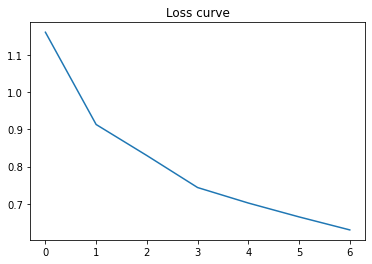

In [200]:
plt.plot(loss_history)
plt.title('Loss curve')
plt.show()

In [201]:
def evaluate(image):
    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = inception_v3(temp_input)

    img_tensor_val = tf.reshape(
        img_tensor_val, 
        (img_tensor_val.shape[0], -1, img_tensor_val.shape[3])
    )

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([word2idx('[start]')], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, _ = decoder(dec_input, features, hidden)

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        predicted_word = tf.compat.as_text(idx2word(predicted_id).numpy())

        if predicted_word == '[end]':
            return result
            
        result.append(predicted_word)

        dec_input = tf.expand_dims([predicted_id], 0)

    return result

Real Caption: Four people with shaved heads and white robes praying .


Prediction Caption: man , both wearing all in the moon and holding star [UNK] . " [UNK] mats . fingers extended . " Ok face masks and standing with two lifts his head on the camera . dance to dancing . "



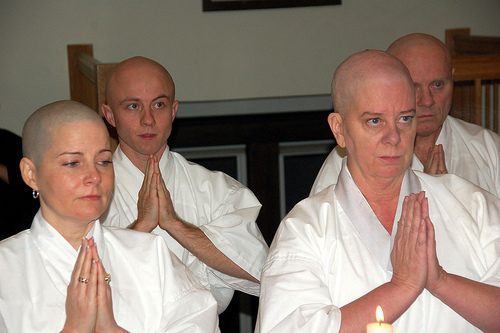

In [207]:
random_row = captions.sample(1).iloc[0]

image = random_row['image']
caption = random_row['caption'] 

result = evaluate(image)

print('Real Caption:', caption)
print('\nPrediction Caption:', ' '.join(result))
print()
Image.open(image)